#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/opt/anaconda3/envs/csma3/bin/python


# Install dependencies:

In [2]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [1]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [2]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

# Set pandas print options
 This will improve readability of printed pandas dataframe.


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [6]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [7]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [8]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [9]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 5 silhouette_avg: 0.282379
n_clusters: 10 silhouette_avg: 0.3443897
n_clusters: 15 silhouette_avg: 0.38070863
n_clusters: 20 silhouette_avg: 0.36556098
n_clusters: 25 silhouette_avg: 0.3519204
n_clusters: 30 silhouette_avg: 0.3452696
n_clusters: 35 silhouette_avg: 0.34582657
n_clusters: 40 silhouette_avg: 0.34683618
n_clusters: 45 silhouette_avg: 0.34131685
n_clusters: 50 silhouette_avg: 0.34406087


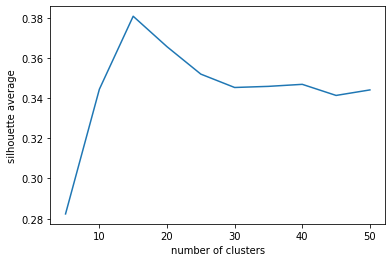

In [17]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters= 5 
max_clusters=55
step=5

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=134 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=300, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [26]:
number_of_clusters =  20
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 15     26
12     26
19     55
17     65
9      77
10     79
16     84
5      87
6     102
11    104
18    111
2     135
13    147
14    148
1     149
8     153
7     161
4     163
3     164
0     256
Name: label_kmedoids, dtype: int64


In [28]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [29]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

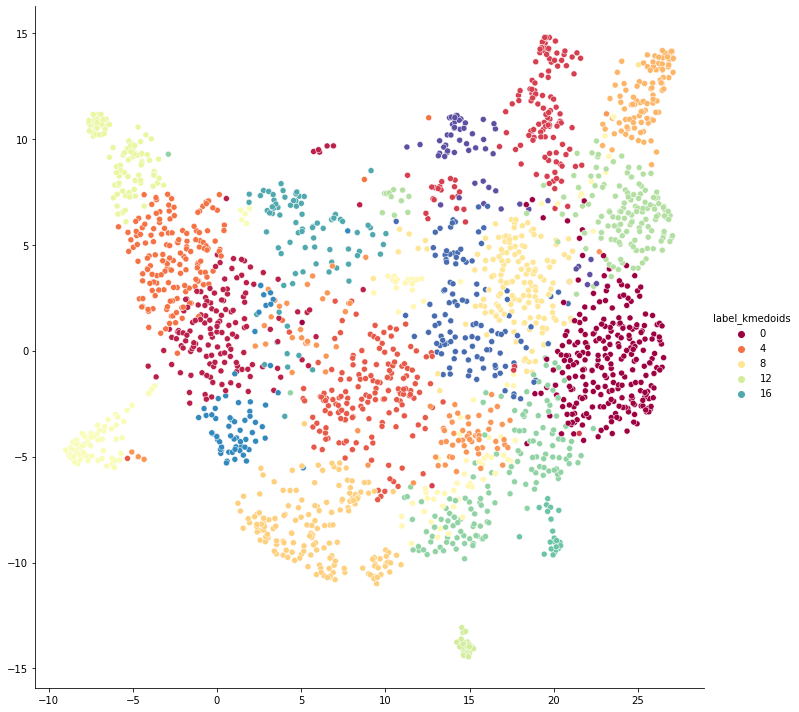

In [30]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Spectral" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 1 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

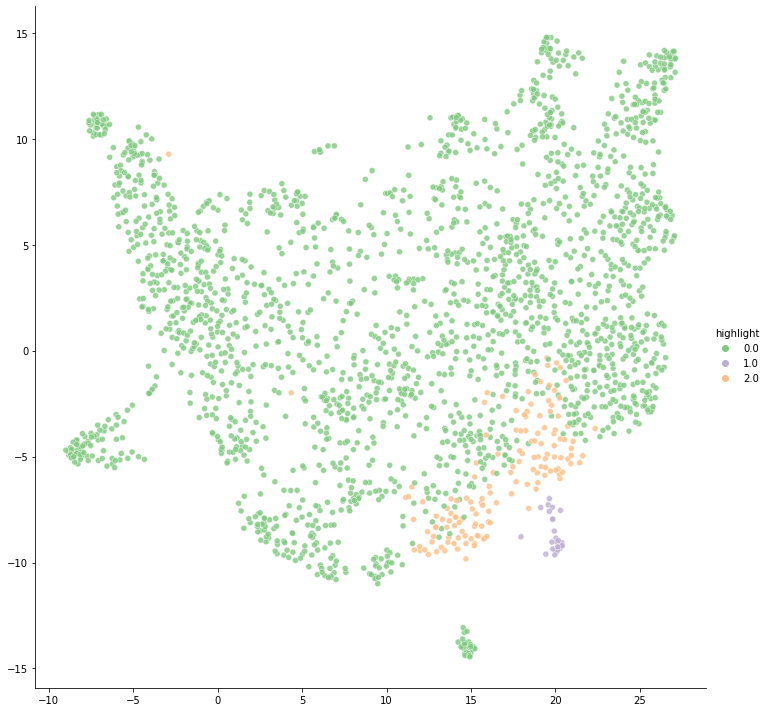

In [36]:
## Choose a cluster to higlight:
cluster_num = 15
cluster_num_2 = 14

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1
data.loc[data['label_kmedoids'] == cluster_num_2, 'highlight'] = 2

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [37]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1119,2019-09-07 03:58:54,Ian Meade,"@Rachel Weiner yes so did I. I was pointing out that because the earth aleady has a major greenhouse effect acting on it, our change doesn't seem like much when in reality it is.",1,"@Rachel Weiner yes so did I. I was pointing out that because the earth aleady\nhas a major greenhouse effect acting on it, our change doesn't seem like much\nwhen in reality it is.\n\n",-1.0,0,0.000000e+00,0.0
1167,2019-09-06 22:28:47,nipnop,I can't believe there are people like you who would rather listen to political propaganda instead of scientists,1,I can't believe there are people like you who would rather listen to political\npropaganda instead of scientists\n\n,-1.0,1,0.000000e+00,0.0
795,2019-09-07 05:28:55,Dracopol,"<a href=""https://www.youtube.com/watch?v=tUR0LrSadkg&amp;t=0m46s"">0:46</a> &quot;Yes, sea levels are rising, but the rise is not accelerating...have shown a small decline in the rate of sea-level increase&quot;.<br />That&#39;s still an increase! This is nonsense. Prager is in the pocket of oil-companies and puts out lots of bafflegab that amounts to it IS getting worse.<br /><a href=""https://features.weather.com/course-climate-misinformation/"">https://features.weather.com/course-climate-misinformation/</a>",0,"0:46 ""Yes, sea levels are rising, but the rise is not accelerating...have\nshown a small decline in the rate of sea-level increase"". \nThat's still an increase! This is nonsense. Prager is in the pocket of oil-\ncompanies and puts out lots of bafflegab that amounts to it IS getting worse. \n\n\n",-1.0,2,0.000000e+00,0.0
1926,2019-09-07 17:53:25,Adorable Deplorable,raymondspogo Exactly . And that acronym is aimed squarely at the democrats . They prove it every day . But there is hope at the end of the proverbial tunnel ....... Trump will win again . Only this time in a landslide .,1,raymondspogo Exactly . And that acronym is aimed squarely at the democrats .\nThey prove it every day . But there is hope at the end of the proverbial\ntunnel ....... Trump will win again . Only this time in a landslide .\n\n,-1.0,3,1.192093e-07,0.0
1538,2020-01-31 04:36:48,Nathan Armstrong,"Mmm...cheeseburgers, you just made me hungry.",1,"Mmm...cheeseburgers, you just made me hungry.\n\n",-1.0,4,5.960464e-08,0.0
1206,2019-09-06 23:07:33,Joe Smith,@nipnop you think I Trust these Scientist who work for the New World Order universities,1,@nipnop you think I Trust these Scientist who work for the New World Order\nuniversities\n\n,-1.0,5,1.192093e-07,0.0
1551,2019-09-09 06:57:32,96stealth,"Be N S O N So I see you are no longer replying to anyone anymore, maybe you will with mine. The earths climate naturally changes right? What’s earths optimal temperature? These are a couple questions never discussed and they’re basic. Why do you think warmer temperature is such a bad thing? I can only assume the hysteria that one side is pushing. Basic arguments aren’t accounted for or even represented correctly. Like the Polar bear argument. Their numbers weren’t researched correctly by people who don’t actually research them. The numbers were down do to over hunting them. They only stabilized & grew once they were protected. Nothing to do with climate change. Some “experts” said they were supposed to be extinct by now. Plus you never answered the Klip guys question of how much of co2 is natural & how much is man made. 97% is natural. How can 3% of anything with many other factors (sun, solar winds, cloud cover etc) affect the clime in such a way that it’s a problem to mankind? The earths climate is capable of getting 30-40F warmer than it is now on its own. This means people literally could not stop temperature increases if we wanted to. So the big question is how much if any are we affecting it? Well one side only seems to be focusing on 1 factor, co2. All factors should be represented. 3% of 1 of many factors is a l

In [38]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  256 mean distance from center:  0.005472637712955475 Proportion of replies: 27.734375
1 number of samples:  149 mean distance from center:  0.004751170126837678 Proportion of replies: 81.20805369127517
2 number of samples:  135 mean distance from center:  0.005244281419436447 Proportion of replies: 35.55555555555556
3 number of samples:  164 mean distance from center:  0.005976565080345608 Proportion of replies: 50.609756097560975
4 number of samples:  163 mean distance from center:  0.0031442363251699135 Proportion of replies: 78.52760736196319
5 number of samples:  87 mean distance from center:  0.005120450077811256 Proportion of replies: 83.9080459770115
6 number of samples:  102 mean distance from center:  0.0019379691366339102 Proportion of replies: 63.72549019607843
7 number of samples:  161 mean distance from center:  0.005908301318413578 Proportion of replies: 31.055900621118013
8 number of samples:  153 mean distance from center:  0.00507103068230208 Prop

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [45]:
# Choose a cluster to print
cluster_number =   14
# Choose the number of samples to print
number_of_samples_to_print = 1000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster['text']


Number of samples in the cluster: 148
Average Distance from cluster center: 7.213894e-05


439                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 What "anti-environmental propaganda" are you talking about? This video literally said, "that doesn't mean its not a reality, or not a problem. It is. But the narrative that the world's climate is changing from bad to worse is unhelpful alarmism that prevents us from focusing on smart solutions."
372                                                                                                                                                        

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [ ]:
#which cluster would you like to assign labels to?
cluster_number = 15
#your label
label_manual = 'rationality'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')